In [1]:
# necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypfopt as pyp
import seaborn as sns
import datetime
import yfinance as yf
idx = pd.IndexSlice
from pandas_datareader import data

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
tickers = [ "HDFCBANK.NS", "IDFCFIRSTB.NS", "PNB.NS", "HINDUNILVR.NS", "ZYDUSWELL.NS", "PGHH.NS", "M&M.NS", "APOLLOTYRE.NS", "HEROMOTOCO.NS", "CIPLA.NS", "GLENMARK.NS",
            "ABBOTINDIA.NS", "INFY.NS", "KPITTECH.NS", "TATAELXSI.NS"] #, "

In [3]:
today = "2022-03-31"
start = "2017-03-31"
prices = pd.DataFrame()
for ticker in tickers:
    try:
        df_ticker = yf.download(ticker, start=start, end=today).rename(columns={"Close": ticker})[[ticker]]
        prices = pd.concat([prices, df_ticker], axis=1)
    except:
        print(ticker)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [4]:
prices = prices.dropna()

In [5]:
mcap_dict = {}
for ticker in tickers:
    mcap_dict[ticker] = data.get_quote_yahoo(ticker)['marketCap'][ticker]

In [6]:
market_prices = yf.download("^NSEI", period="max")["Adj Close"]


[*********************100%***********************]  1 of 1 completed


In [7]:
S = pyp.risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = pyp.black_litterman.market_implied_risk_aversion(market_prices, risk_free_rate=0.05796)
print(delta)

1.0938440133318355


Text(0.5, 1.0, 'Assets Correlation Matrix')

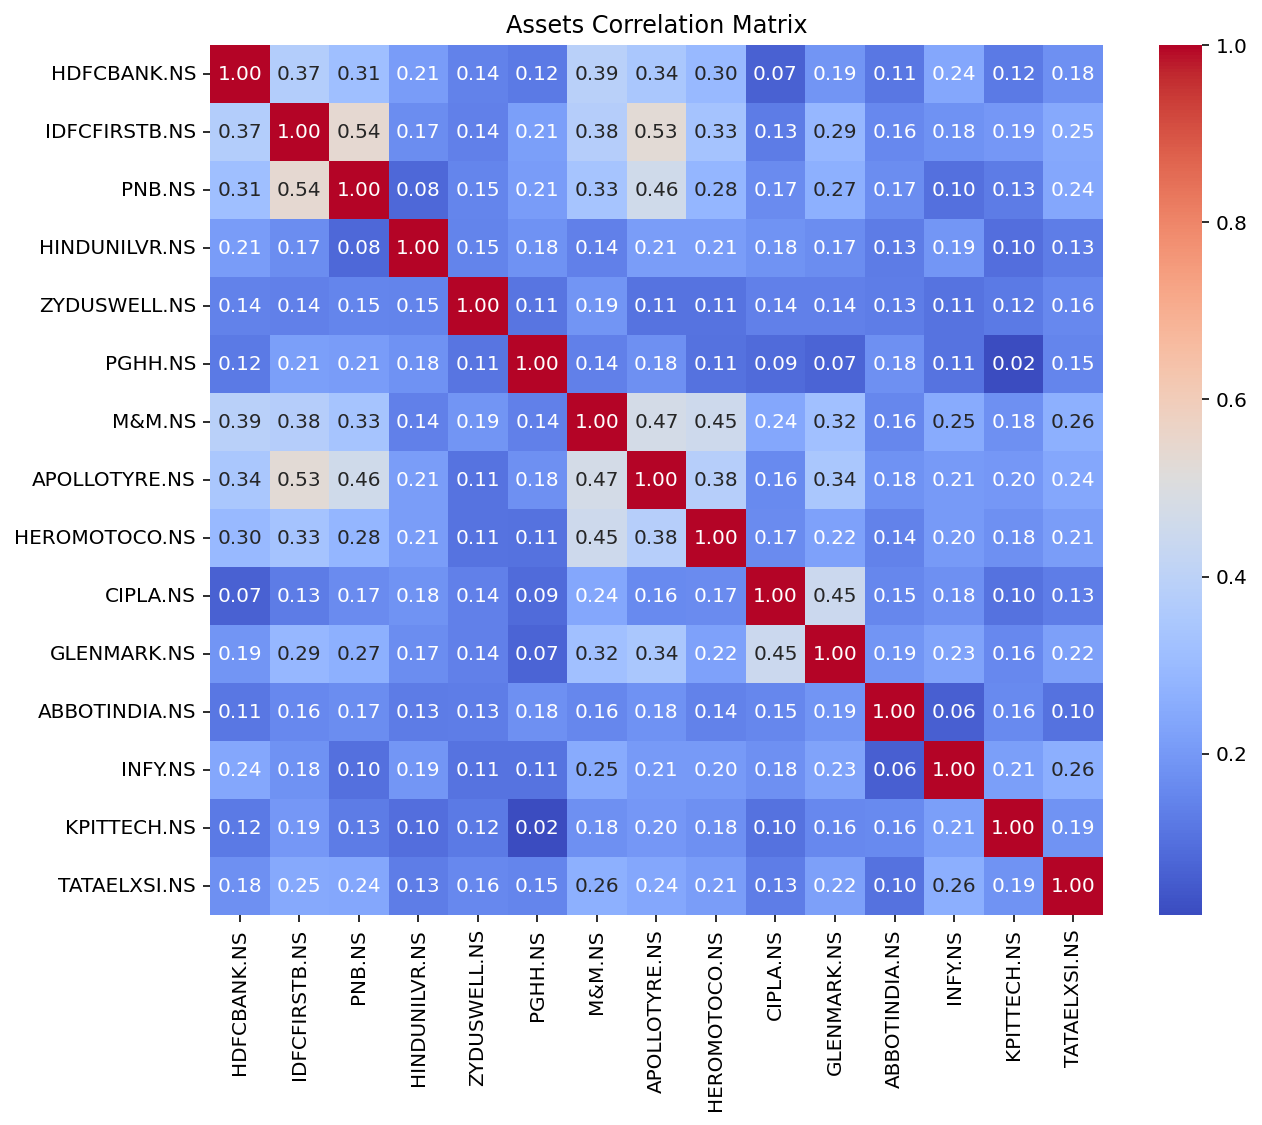

In [8]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(prices.pct_change().corr(method ='spearman'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f")
ax.set_title('Assets Correlation Matrix')


In [9]:
market_prior = pyp.black_litterman.market_implied_prior_returns(mcap_dict, delta, S)
market_prior.name = 'Prior'
print(market_prior)

HDFCBANK.NS      0.076348
IDFCFIRSTB.NS    0.072077
PNB.NS           0.057113
HINDUNILVR.NS    0.057841
ZYDUSWELL.NS     0.035616
PGHH.NS          0.036463
M&M.NS           0.070315
APOLLOTYRE.NS    0.068456
HEROMOTOCO.NS    0.063202
CIPLA.NS         0.040977
GLENMARK.NS      0.053853
ABBOTINDIA.NS    0.041027
INFY.NS          0.070644
KPITTECH.NS      0.049297
TATAELXSI.NS     0.061919
Name: Prior, dtype: float64


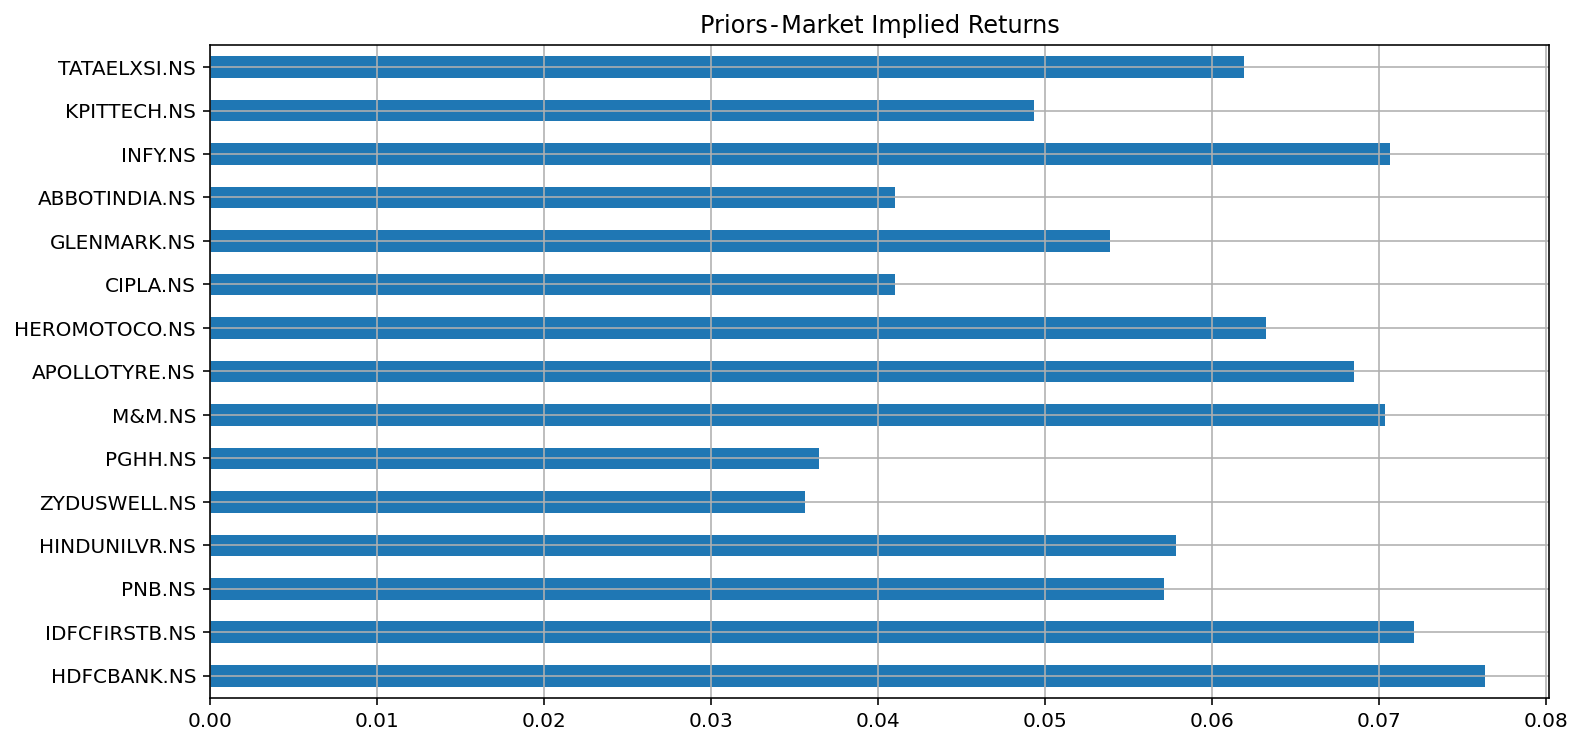

In [12]:
# plot prior
market_prior.plot.barh(figsize=(12,6), title = 'Priors - Market Implied Returns',grid=True);


In [15]:
view_confidence  = pd.DataFrame()
view_confidence.index = tickers
view_confidence["View"] = 0
view_confidence["Confidences"] = 0

In [17]:
views_dict = {ind : view_confidence['View'][ind] for ind in view_confidence.index}
print(views_dict)

{'HDFCBANK.NS': 0, 'IDFCFIRSTB.NS': 0, 'PNB.NS': 0, 'HINDUNILVR.NS': 0, 'ZYDUSWELL.NS': 0, 'PGHH.NS': 0, 'M&M.NS': 0, 'APOLLOTYRE.NS': 0, 'HEROMOTOCO.NS': 0, 'CIPLA.NS': 0, 'GLENMARK.NS': 0, 'ABBOTINDIA.NS': 0, 'INFY.NS': 0, 'KPITTECH.NS': 0, 'TATAELXSI.NS': 0}


In [18]:
bl = pyp.BlackLittermanModel(S, pi=market_prior, absolute_views=views_dict)

In [19]:
bl_return = bl.bl_returns()
bl_return.name = 'Posterior'

In [20]:
mu = pyp.expected_returns.mean_historical_return(prices)
mu.name = 'Historical'

In [22]:
returns_df = pd.DataFrame([market_prior, mu, bl_return, pd.Series(views_dict)], 
             index=['Prior', 'Historical','Posterior', 'Views']).T
print(returns_df)

                  Prior  Historical  Posterior  Views
HDFCBANK.NS    0.076348    0.095660   0.021364    0.0
IDFCFIRSTB.NS  0.072077   -0.095087   0.005525    0.0
PNB.NS         0.057113   -0.268973   0.006121    0.0
HINDUNILVR.NS  0.057841    0.052299   0.015999    0.0
ZYDUSWELL.NS   0.035616    0.052765   0.008397    0.0
PGHH.NS        0.036463    0.102348   0.009269    0.0
M&M.NS         0.070315    0.058384   0.009859    0.0
APOLLOTYRE.NS  0.068456   -0.036230   0.006101    0.0
HEROMOTOCO.NS  0.063202   -0.056772   0.009906    0.0
CIPLA.NS       0.040977    0.233562   0.008998    0.0
GLENMARK.NS    0.053853   -0.108269   0.005164    0.0
ABBOTINDIA.NS  0.041027    0.321882   0.008041    0.0
INFY.NS        0.070644    0.399490   0.021409    0.0
KPITTECH.NS    0.049297    0.832034   0.007604    0.0
TATAELXSI.NS   0.061919    1.172516   0.008762    0.0


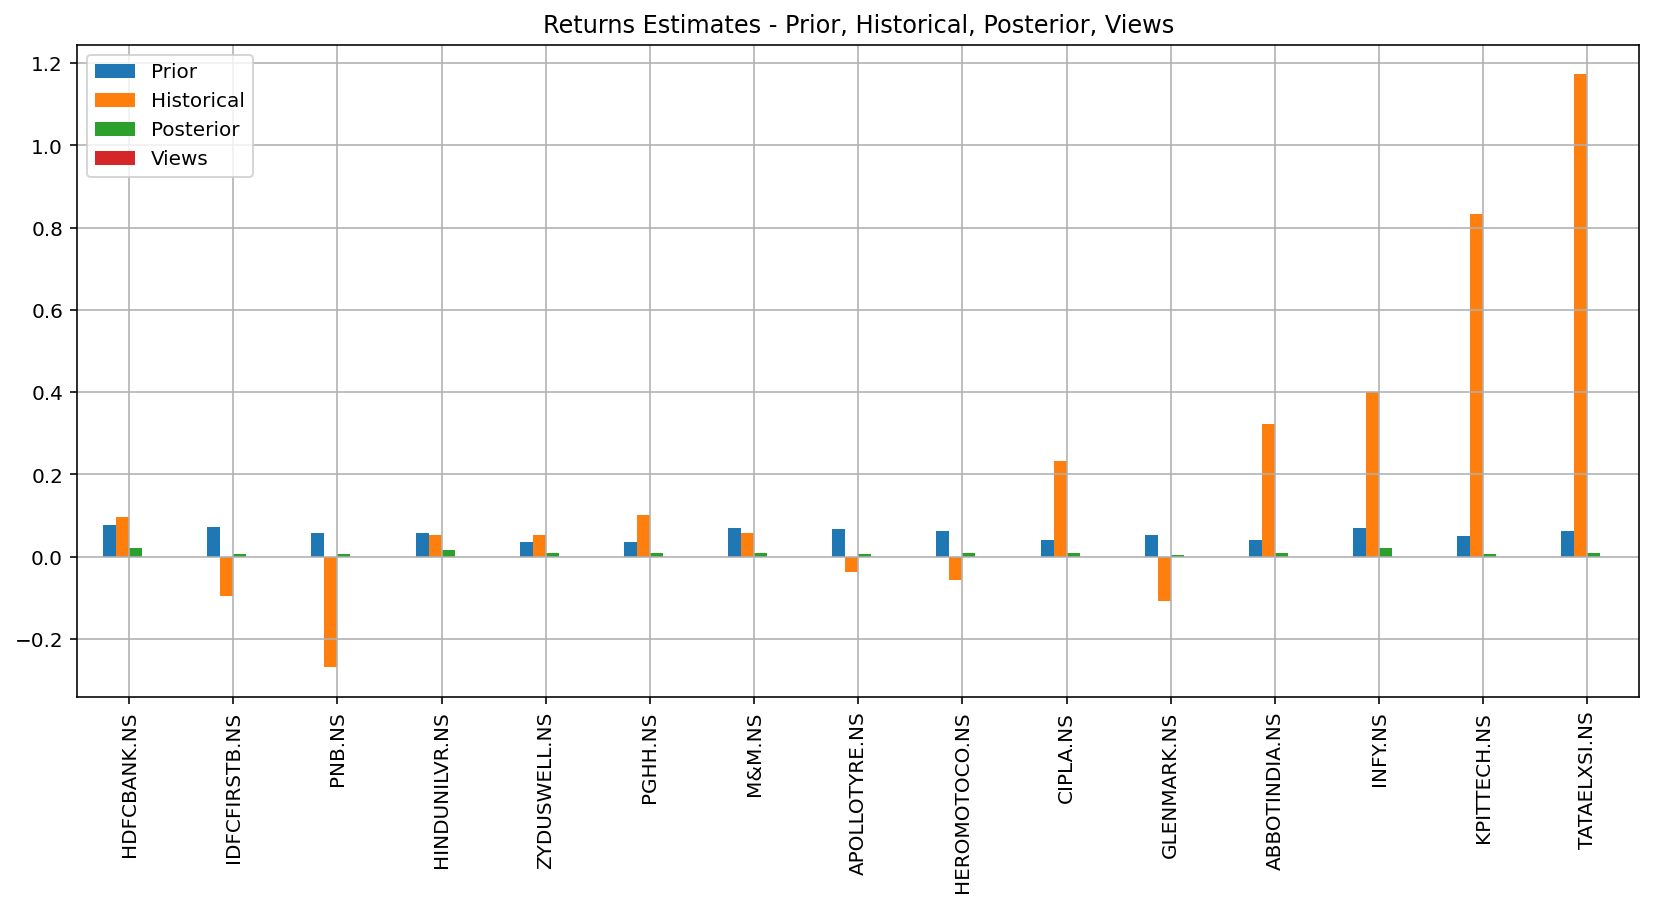

In [23]:
returns_df.plot.bar(figsize=(14,6), title = 'Returns Estimates - Prior, Historical, Posterior, Views', grid=True);

In [24]:
S_bl = bl.bl_cov()

In [25]:
confidences = list(view_confidence.Confidences)
print(confidences)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [26]:
bl_confi = pyp.BlackLittermanModel(S, pi=market_prior, 
                                   absolute_views=views_dict, 
                                   omega="idzorek", view_confidences=confidences)

In [27]:
bl_return_confi = bl_confi.bl_returns()
bl_return_confi.name = 'Posterior_confidence'

In [28]:
returns_df = pd.DataFrame([market_prior, mu, bl_return, pd.Series(views_dict), bl_return_confi], 
             index=['Prior', 'Historical','Posterior', 'Views', 'Posterior_confidence']).T
print(returns_df)

                  Prior  Historical  Posterior  Views  Posterior_confidence
HDFCBANK.NS    0.076348    0.095660   0.021364    0.0              0.076348
IDFCFIRSTB.NS  0.072077   -0.095087   0.005525    0.0              0.072077
PNB.NS         0.057113   -0.268973   0.006121    0.0              0.057113
HINDUNILVR.NS  0.057841    0.052299   0.015999    0.0              0.057841
ZYDUSWELL.NS   0.035616    0.052765   0.008397    0.0              0.035616
PGHH.NS        0.036463    0.102348   0.009269    0.0              0.036463
M&M.NS         0.070315    0.058384   0.009859    0.0              0.070315
APOLLOTYRE.NS  0.068456   -0.036230   0.006101    0.0              0.068456
HEROMOTOCO.NS  0.063202   -0.056772   0.009906    0.0              0.063202
CIPLA.NS       0.040977    0.233562   0.008998    0.0              0.040977
GLENMARK.NS    0.053853   -0.108269   0.005164    0.0              0.053853
ABBOTINDIA.NS  0.041027    0.321882   0.008041    0.0              0.041027
INFY.NS     

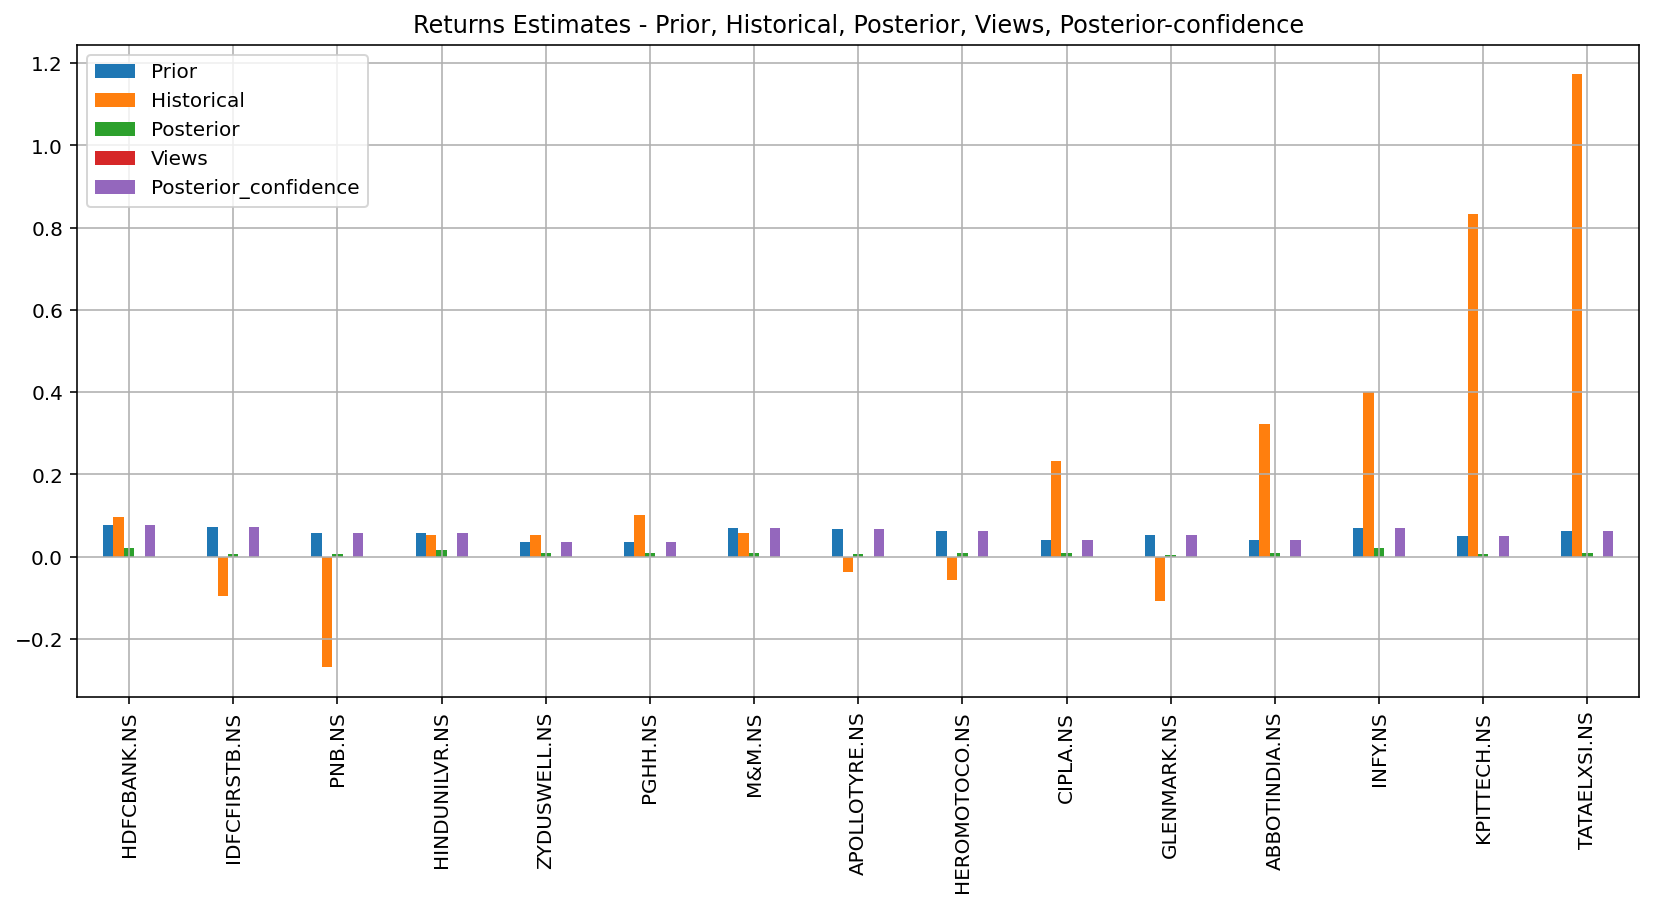

In [30]:
returns_df.plot.bar(figsize=(14,6), 
                    title = 'Returns Estimates - Prior, Historical, Posterior, Views, Posterior-confidence', grid=True);

In [31]:
S_bl_confi = bl_confi.bl_cov()
S_bl_confi

,HDFCBANK.NS,IDFCFIRSTB.NS,PNB.NS,HINDUNILVR.NS,ZYDUSWELL.NS,PGHH.NS,M&M.NS,APOLLOTYRE.NS,HEROMOTOCO.NS,CIPLA.NS,GLENMARK.NS,ABBOTINDIA.NS,INFY.NS,KPITTECH.NS,TATAELXSI.NS
HDFCBANK.NS,0.102363,0.065985,0.047194,0.025791,0.015436,0.016077,0.059135,0.057615,0.050032,0.010571,0.029666,0.019205,0.032201,0.028879,0.035908
IDFCFIRSTB.NS,0.065985,0.225224,0.114284,0.027827,0.024811,0.031423,0.077575,0.109835,0.062076,0.024526,0.073059,0.028028,0.036749,0.060108,0.064214
PNB.NS,0.047194,0.114284,0.202316,0.015043,0.023327,0.026659,0.057929,0.091955,0.045683,0.020964,0.055342,0.028554,0.022885,0.027872,0.049983
HINDUNILVR.NS,0.025791,0.027827,0.015043,0.077119,0.014806,0.018225,0.021868,0.029177,0.030008,0.017160,0.023093,0.022735,0.025993,0.012747,0.027592
ZYDUSWELL.NS,0.015436,0.024811,0.023327,0.014806,0.096588,0.008802,0.023199,0.017189,0.016341,0.014242,0.024603,0.013775,0.010062,0.020087,0.024636
PGHH.NS,0.016077,0.031423,0.026659,0.018225,0.008802,0.066898,0.019429,0.027140,0.013420,0.007115,0.015046,0.017865,0.009229,0.008351,0.015482
M&M.NS,0.059135,0.077575,0.057929,0.021868,0.023199,0.019429,0.157725,0.081634,0.071001,0.037800,0.045826,0.022713,0.033962,0.044110,0.061714
APOLLOTYRE.NS,0.057615,0.109835,0.091955,0.029177,0.017189,0.027140,0.081634,0.187533,0.063018,0.022279,0.064541,0.031339,0.036156,0.052560,0.055701
HEROMOTOCO.NS,0.050032,0.062076,0.045683,0.030008,0.016341,0.013420,0.071001,0.063018,0.129817,0.021077,0.036946,0.022150,0.031421,0.037782,0.043430
CIPLA.NS,0.010571,0.024526,0.020964,0.017160,0.014242,0.007115,0.037800,0.022279,0.021077,0.101031,0.057316,0.023039,0.020272,0.018350,0.023825


In [38]:
# Long-only minimum volatility portfolio, with a weight cap of 10% and regularisation
ef = pyp.EfficientFrontier(bl_return_confi, S_bl_confi, weight_bounds=(0, 1))
ef.add_objective(pyp.objective_functions.L2_reg, gamma=0.1)
weights = ef.min_volatility()
ef.portfolio_performance(verbose=True), print('\n')
wt_min_vola = pd.DataFrame([weights],columns=weights.keys()).T * 100

print ('Weights in Percentage ********************')
print(wt_min_vola.round(4))

Expected annual return: 5.1%
Annual volatility: 16.7%
Sharpe Ratio: 0.18


Weights in Percentage ********************
                     0
HDFCBANK.NS     7.8087
IDFCFIRSTB.NS   0.0000
PNB.NS          3.3282
HINDUNILVR.NS  11.2122
ZYDUSWELL.NS   12.9376
PGHH.NS        16.0682
M&M.NS          1.5572
APOLLOTYRE.NS   0.4014
HEROMOTOCO.NS   5.2025
CIPLA.NS       11.2141
GLENMARK.NS     2.2772
ABBOTINDIA.NS  10.6736
INFY.NS         9.6729
KPITTECH.NS     4.6834
TATAELXSI.NS    2.9630


In [39]:
(wt_min_vola.round(4)[0])

HDFCBANK.NS       7.8087
IDFCFIRSTB.NS     0.0000
PNB.NS            3.3282
HINDUNILVR.NS    11.2122
ZYDUSWELL.NS     12.9376
PGHH.NS          16.0682
M&M.NS            1.5572
APOLLOTYRE.NS     0.4014
HEROMOTOCO.NS     5.2025
CIPLA.NS         11.2141
GLENMARK.NS       2.2772
ABBOTINDIA.NS    10.6736
INFY.NS           9.6729
KPITTECH.NS       4.6834
TATAELXSI.NS      2.9630
Name: 0, dtype: float64

In [43]:
(list(wt_min_vola.round(4)[0]))

[7.8087,
 0.0,
 3.3282,
 11.2122,
 12.9376,
 16.0682,
 1.5572,
 0.4014,
 5.2025,
 11.2141,
 2.2772,
 10.6736,
 9.6729,
 4.6834,
 2.963]